# Introduction

# Airbnb Data Analysis

In this notebook, we will explore Airbnb data to uncover insights into shared accommodations. We will tackle the following key business questions:

1. **What are the peak seasons for bookings, and how do prices fluctuate throughout the year?**
2. **What are the key factors that influence the ratings of a listing?**
3. **How do review trends vary across different property types and locations?**

Let's begin by importing the necessary libraries and loading the data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

# Path to extracted data
extract_path = 'data'

# Loading listings.csv, calendar.csv, reviews.csv files
listings_df = pd.read_csv(os.path.join(extract_path, 'listings.csv'))
calendar_df = pd.read_csv(os.path.join(extract_path, 'calendar.csv'))
reviews_df = pd.read_csv(os.path.join(extract_path, 'reviews.csv'))

### Data Understanding

#### Snippet of Data

In [2]:
# Displaying the first few rows of each DataFrame
listings_df.head(), calendar_df.head(), reviews_df.head()

(        id                           listing_url       scrape_id last_scraped  \
 0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
 1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
 2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
 3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
 4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   
 
                                   name  \
 0         Stylish Queen Anne Apartment   
 1   Bright & Airy Queen Anne Apartment   
 2  New Modern House-Amazing water view   
 3                   Queen Anne Chateau   
 4       Charming craftsman 3 bdm house   
 
                                              summary  \
 0                                                NaN   
 1  Chemically sensitive? We've removed the irrita...   
 2  New modern house built in 2013.  Spectacular s...   
 3  A charming apa

#### Identify Metadata

In [3]:
# Displaying the metadata
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [4]:
# Displaying the metadata
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [5]:
# Displaying the metadata
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


#### Checking Missing Value

In [6]:
def count_missing_values(calendar_df, listings_df, reviews_df):
    """
    Counts the number of columns with missing values for each provided dataframe.
    
    Parameters:
    - calendar_df (pd.DataFrame): The dataframe containing calendar data.
    - listings_df (pd.DataFrame): The dataframe containing listings data.
    - reviews_df (pd.DataFrame): The dataframe containing reviews data.
    
    Returns:
    - tuple: A tuple containing the count of columns with missing values for:
        1. calendar_df
        2. listings_df
        3. reviews_df
    """
    
    count_mv_calendar = calendar_df.isnull().sum()
    count_col_mv_calendar = count_mv_calendar[count_mv_calendar>0].count()

    count_mv_listing = listings_df.isnull().sum()
    count_col_mv_listing = count_mv_listing[count_mv_listing>0].count()

    count_mv_review = reviews_df.isnull().sum()
    count_col_mv_review = count_mv_review[count_mv_review>0].count()

    return (
        count_col_mv_calendar,
        count_col_mv_listing,
        count_col_mv_review
    )


In [7]:
## How many column are missing each dataset
count_missing_values(calendar_df,listings_df,reviews_df)

(1, 45, 1)

In [8]:
def show_missing_column(df):
    """
    Identifies and returns columns with missing values from the provided dataframe.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe to check for missing values.
    
    Returns:
    - pd.Series: A series containing counts of missing values for columns that have them.
    """
    
    missing_sum = df.isnull().sum()
    list_col_missing = missing_sum[missing_sum > 0]
    return list_col_missing
    


In [9]:
## Variable missing for calendar_df
show_missing_column(calendar_df)

price    459028
dtype: int64

In [10]:
## Variable missing for reviews_df
show_missing_column(reviews_df)

comments    18
dtype: int64

In [11]:
## Variable missing for listings_df
show_missing_column(listings_df)

summary                         177
space                           569
neighborhood_overview          1032
notes                          1606
transit                         934
thumbnail_url                   320
medium_url                      320
xl_picture_url                  320
host_name                         2
host_since                        2
host_location                     8
host_about                      859
host_response_time              523
host_response_rate              523
host_acceptance_rate            773
host_is_superhost                 2
host_thumbnail_url                2
host_picture_url                  2
host_neighbourhood              300
host_listings_count               2
host_total_listings_count         2
host_has_profile_pic              2
host_identity_verified            2
neighbourhood                   416
zipcode                           7
property_type                     1
bathrooms                        16
bedrooms                    

In [12]:
## Checking by case calendar
calendar_df[calendar_df['price'].isnull()].sample(5)

,listing_id,date,available,price
443326,6958436,2016-08-07,f,NaN
385624,2387605,2016-07-06,f,NaN
1384338,9288840,2016-09-18,f,NaN
1375020,8632651,2016-03-09,f,NaN
1027535,6769696,2016-03-04,f,NaN


In [13]:
## Checking by case calendar
reviews_df[reviews_df['comments'].isnull()].sample(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
31414,3354614,18103248,2014-08-21,12426758,Jeff,NaN
40176,23430,8347394,2013-10-27,5034901,Jim,NaN
76589,84030,11782337,2014-04-14,5270791,Robert,NaN
35210,3554558,24863045,2015-01-03,24488791,Eleanor,NaN
61176,5682,64918,2010-07-15,145644,Keri,NaN


### Handling Missing Value

#### Calendar Dataset

There is a lot of missing value for price column. That exists, because of the listing is not available.
So the solution of this case is fill missing value with negative value.

In [14]:
def remove_missing_value_calendar(df):
    """
    Removes rows with any missing values from the provided dataframe.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe from which to remove rows with missing values.
    
    Returns:
    - pd.DataFrame: The dataframe after removing rows with any missing values.
    """
    
    df['price'] = df['price'].fillna(-1)
    return df

calendar_df = remove_missing_value_calendar(calendar_df)

In [15]:
## Variable missing for calendar_df
show_missing_column(calendar_df)

Series([], dtype: int64)

#### Listings Dataset

There is 45 column that have missing data. So there are several treatment that will be applied here.
For numerical column, we will fill with zero because it is the safest method that could be applied.
For categorical column, we will fill with "Unknown".

In [16]:
def fill_missing_values_listing(df):
    """
    Fills missing values in the dataframe. For numerical columns, fills with 0. 
    For categorical columns, fills with 'Unknown'.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe with missing values.
    
    Returns:
    - pd.DataFrame: The dataframe after filling missing values.
    """
    missing_values_series = df.isnull().sum()
    
    columns_with_missing_values = missing_values_series[missing_values_series > 0]

    # Categorizing columns based on their data type
    numerical_columns = df[columns_with_missing_values.index].select_dtypes(include=['float64', 'int64']).columns
    categorical_columns = df[columns_with_missing_values.index].select_dtypes(include=['object']).columns

    df[numerical_columns] = df[numerical_columns].fillna(0)
    df[categorical_columns] = df[categorical_columns].fillna('Unknown')
    
    return df


In [17]:
listings_df = fill_missing_values_listing(listings_df)

In [18]:
## Variable missing for listings_df
show_missing_column(listings_df)

Series([], dtype: int64)

#### Reviews Dataset

There is only 18 review that have missing value. In the next section we will replace this missing value with the empty string.

In [19]:
def fill_missing_value_reviews(df):
    """
    Fills missing values in the 'comments' column of the provided dataframe with an empty string.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe with potential missing values in the 'comments' column.
    
    Returns:
    - pd.Series: The 'comments' series after filling missing values with an empty string.
    """
    
    df['comments'] = df['comments'].fillna('')
    return df


reviews_df = fill_missing_value_reviews(reviews_df)    

In [20]:
## Variable missing for reviews_df
show_missing_column(reviews_df)

Series([], dtype: int64)

#### Checking Duplicate Rows

In [21]:
def check_duplicate_rows(calendar_df, listings_df, reviews_df):
    """
    Checks and returns the count of duplicate rows for each provided dataframe.
    
    Parameters:
    - calendar_df (pd.DataFrame): The dataframe containing calendar data.
    - listings_df (pd.DataFrame): The dataframe containing listings data.
    - reviews_df (pd.DataFrame): The dataframe containing reviews data.
    
    Returns:
    - tuple: A tuple containing the count of duplicate rows for:
        1. calendar_df
        2. listings_df
        3. reviews_df
    """
    
    duplicate_rows_calendar = calendar_df.duplicated().sum()
    duplicate_rows_listings = listings_df.duplicated().sum()
    duplicate_rows_reviews = reviews_df.duplicated().sum()

    return (
        duplicate_rows_calendar,
        duplicate_rows_listings,
        duplicate_rows_reviews
    )


In [22]:
check_duplicate_rows(calendar_df,listings_df,reviews_df)

(0, 0, 0)

There is no duplicate row in all dataset

### Data Processing

In [23]:
# Function to clean and preprocess the calendar data
def preprocess_calendar_data(df):
    """
    Preprocesses the given calendar DataFrame by performing the following operations:
    1. Removes dollar signs and commas from the 'price' column and converts it to float.
    2. Converts the 'date' column to a datetime format.
    3. Converts the 'available' column to a boolean format: 
       True for available ('t') and False for not available ('f').

    Parameters:
    -----------
    df : pandas.DataFrame
        The input calendar DataFrame with columns 'price', 'date', and 'available'.

    Returns:
    --------
    pandas.DataFrame
        The preprocessed calendar DataFrame.
    """
    # Removing the dollar sign and commas from the price column
    df['price'] = (
        df['price']
        .replace('[\$,]', '', regex=True)
        .astype(float)
    )

    # Converting the date column to a datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Converting the available column to a boolean format
    # (True for available, False for not available)
    df['available'] = df['available'] == 't'

    return df


# Applying the preprocessing function to the calendar DataFrame
calendar_df_cleaned = preprocess_calendar_data(calendar_df.copy())

# Displaying the first few rows of the cleaned DataFrame
calendar_df_cleaned.head()


,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,-1.0
3,241032,2016-01-07,False,-1.0
4,241032,2016-01-08,False,-1.0


### Business Question 1: Peak Seasons and Price Fluctuations

#### Peak Booking Seasons

We'll start by analyzing the booking patterns to identify peak seasons.


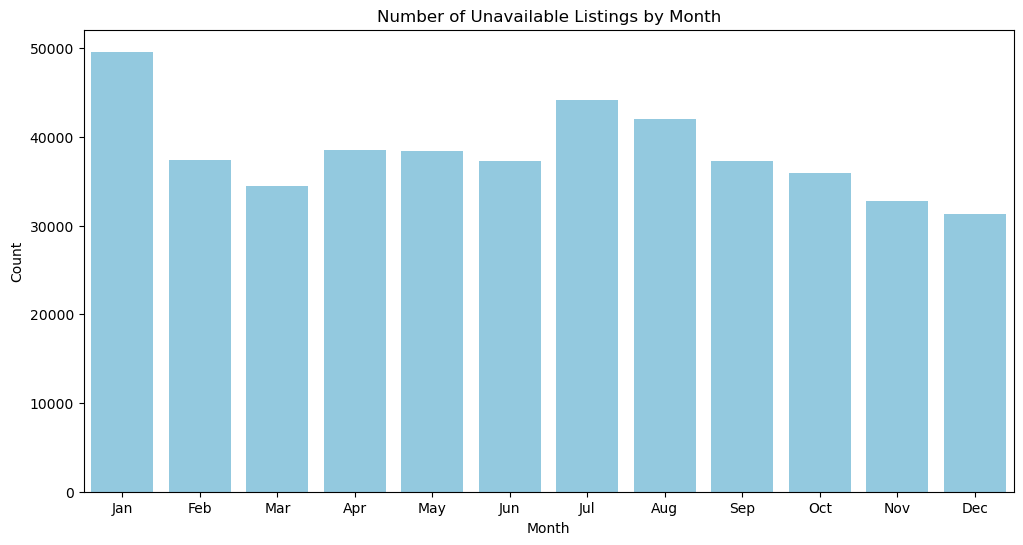

In [24]:
def plot_unavailable_listings_by_month(calendar_df):
    """
    Plot the number of unavailable listings by month from a given DataFrame.

    Parameters:
    - calendar_df (pd.DataFrame): The input dataframe which must contain columns 
                                  'date' (of datetime type) and 'available' (boolean type).

    Returns:
    - None: The function directly plots the graph without returning any value.
    """
    
    # Extracting the month from the date
    calendar_df['month'] = calendar_df['date'].dt.month

    # Grouping by month and counting the number of unavailable listings
    unavailable_by_month = calendar_df[~calendar_df['available']].groupby('month').size().reset_index(name='count')

    # Plotting the unavailable listings by month
    plt.figure(figsize=(12, 6))
    sns.barplot(x='month', y='count', data=unavailable_by_month, color='skyblue')
    plt.title('Number of Unavailable Listings by Month')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.show()

plot_unavailable_listings_by_month(calendar_df_cleaned)

#### Price Trends

Next, we'll explore how prices fluctuate throughout the year.


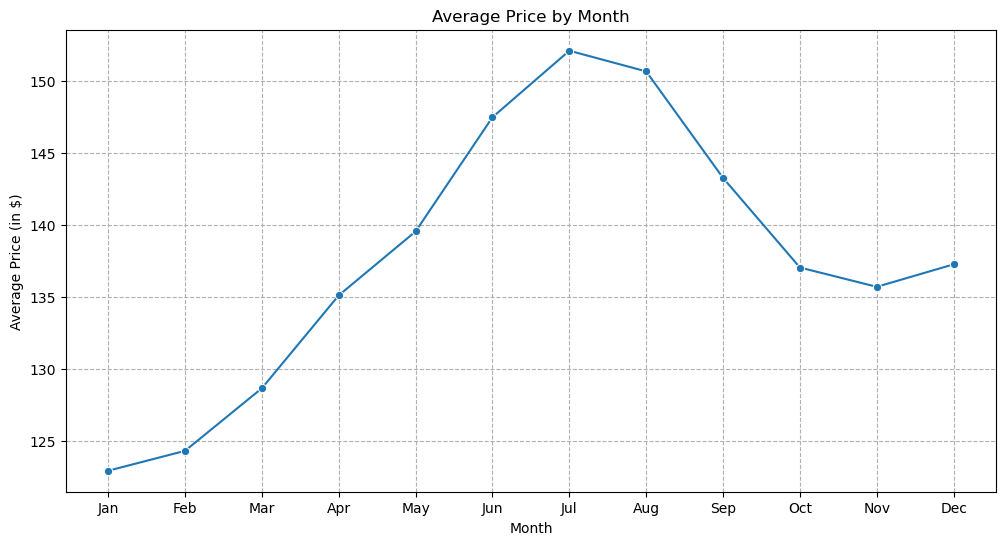

In [25]:
def plot_average_price_by_month(df):
    """
    Plots the average price by month for available listings.

    Parameters:
    - df: DataFrame containing the calendar data with columns 'date', 'available', and 'price'.

    Returns:
    - A line plot showing the average price by month.
    """

    # Extracting the month from the 'date' column and adding it as a new column
    df['month'] = pd.to_datetime(df['date']).dt.month
    
    # Grouping by month and calculating the average price for available listings
    average_price_by_month = df[df['available'] == True].groupby('month')['price'].mean().reset_index()

    # Plotting the average price by month
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='month', y='price', data=average_price_by_month, marker='o')
    plt.title('Average Price by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Price (in $)')
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, linestyle='--')
    plt.show()

# Implement the function
plot_average_price_by_month(calendar_df_cleaned)

#### Insights

- **For Hosts:** Tailor pricing strategies to seasonal demand.
- **For Guests:** Plan bookings during off-peak seasons to find lower prices.


### Business Question 2: Influencing Factors for Ratings

#### Data Preprocessing

We'll start by selecting relevant features and preprocessing the data to understand the key factors influencing ratings.


In [26]:
# Function to clean and preprocess the listings data
def preprocess_listings_data(df):
    """
    Cleans and preprocesses the listings data by selecting relevant columns, 
    and transforming specific columns to appropriate data types.
    
    Parameters:
    - df (pd.DataFrame): The raw listings dataframe to be preprocessed.
    
    Returns:
    - pd.DataFrame: The preprocessed listings dataframe with selected columns and transformed data types.
    """
    # Selecting a subset of columns that are likely to influence the rating of a listing
    columns_to_keep = ['host_response_time', 'host_response_rate', 'host_is_superhost',
                       'property_type', 'room_type', 'accommodates', 'bathrooms',
                       'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating']
    df = df[columns_to_keep]

    # Removing the percentage sign from the host_response_rate column and converting it to a float
    df['host_response_rate'] = df['host_response_rate'].replace('[\%,]', '', regex=True)
    df['host_response_rate'] = df['host_response_rate'].replace('Unknown', np.nan).astype(float)
    df['host_response_rate'] = df['host_response_rate'].fillna(-1)
    
    # Removing the dollar sign and commas from the price column and converting it to a float
    df['price'] = df['price'].replace('[\$,]', '', regex=True)
    df['price'] = df['price'].replace('Unknown', np.nan).astype(float)
    df['price'] = df['price'].fillna(-1)

    # Converting the host_is_superhost column to a boolean format
    df['host_is_superhost'] = df['host_is_superhost'] == 't'

    return df

# Applying the preprocessing function to the listings DataFrame
listings_df_cleaned = preprocess_listings_data(listings_df.copy())

# Displaying the first few rows of the cleaned DataFrame
listings_df_cleaned.head()


,host_response_time,host_response_rate,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating
0,within a few hours,96.0,False,Apartment,Entire home/apt,4,1.0,1.0,1.0,85.0,207,95.0
1,within an hour,98.0,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,150.0,43,96.0
2,within a few hours,67.0,False,House,Entire home/apt,11,4.5,5.0,7.0,975.0,20,97.0
3,Unknown,-1.0,False,Apartment,Entire home/apt,3,1.0,0.0,2.0,100.0,0,0.0
4,within an hour,100.0,False,House,Entire home/apt,6,2.0,3.0,3.0,450.0,38,92.0


#### Correlation Analysis

We'll now analyze the correlations between different features and review scores to identify the key factors influencing ratings.


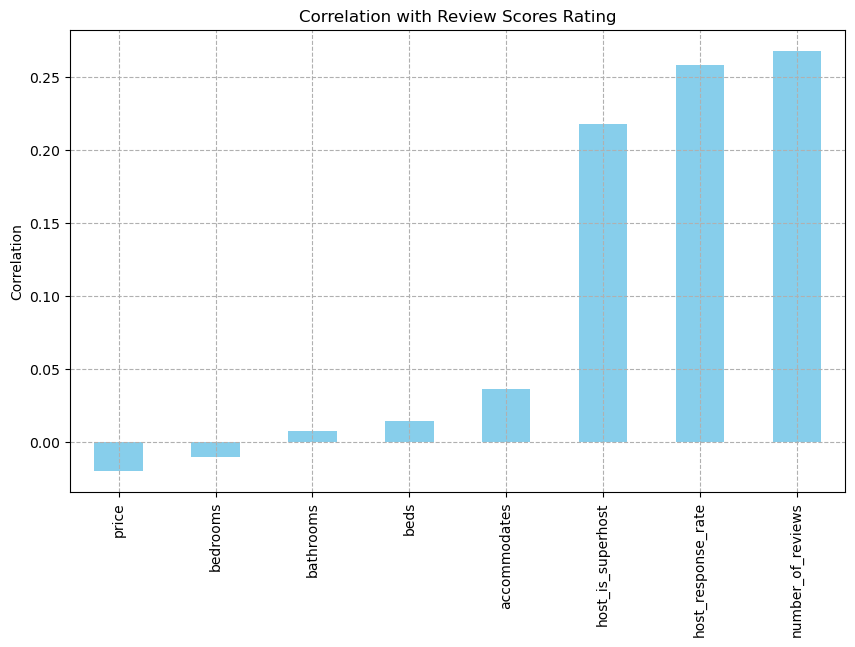

In [27]:
def plot_correlation_with_reviews(df):
    """
    Plots the correlations of all numerical columns with the 'review_scores_rating' column.
    
    Parameters:
    - df (pd.DataFrame): The dataframe containing listings data and the 'review_scores_rating' column.
    
    Returns:
    - A bar plot visualizing the correlation of all numerical columns with 'review_scores_rating'.
    """
    
    # Calculating the correlation with the review_scores_rating column
    correlations = df.corr()['review_scores_rating'].sort_values()

    # Removing the review_scores_rating correlation with itself
    correlations = correlations.drop('review_scores_rating')

    # Plotting the correlations
    plt.figure(figsize=(10, 6))
    correlations.plot(kind='bar', color='skyblue')
    plt.title('Correlation with Review Scores Rating')
    plt.ylabel('Correlation')
    plt.grid(True, linestyle='--')
    plt.show()

# Implement function
plot_correlation_with_reviews(listings_df_cleaned)


#### Insights

- **Number of Reviews:** More reviews might slightly dampen ratings.
- **Superhost Status:** Higher ratings often accompany superhost status.
- **Property Size and Capacity:** Bigger properties generally fare better.
- **Host Responsiveness:** Quick replies please guests.
- **Price:** Higher prices may reflect better experiences.


### Business Question 3: Review Trends Across Property Types and Locations

#### Data Processing

In [28]:
def merge_reviews_with_listings(reviews, listings):
    """
    Merges reviews data with listings data based on the 'listing_id' column.
    
    Parameters:
    - reviews (pd.DataFrame): The reviews dataframe containing review data and a 'listing_id' column.
    - listings (pd.DataFrame): The listings dataframe containing listing data and an 'id' column.
    
    Returns:
    - pd.DataFrame: A merged dataframe of reviews and listings based on the 'listing_id'.
    """
    
    # Selecting relevant columns from the listings DataFrame for the merge
    listings_columns_for_merge = ['id', 'property_type', 'neighbourhood_cleansed', 'latitude', 'longitude']
    listings = listings[listings_columns_for_merge]

    # Renaming the 'id' column to 'listing_id' in the listings DataFrame
    listings = listings.rename(columns={'id': 'listing_id'})

    # Merging the reviews and selected listings data on the 'listing_id' column
    merged_data = pd.merge(reviews, listings, on='listing_id', how='left')
    
    return merged_data

# Implement
merged_reviews_data = merge_reviews_with_listings(reviews_df, listings_df)
merged_reviews_data.head()


,listing_id,id,date,reviewer_id,reviewer_name,comments,property_type,neighbourhood_cleansed,latitude,longitude
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,Apartment,Lower Queen Anne,47.62621,-122.360147
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,Apartment,Lower Queen Anne,47.62621,-122.360147
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",Apartment,Lower Queen Anne,47.62621,-122.360147
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,Apartment,Lower Queen Anne,47.62621,-122.360147
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,Apartment,Lower Queen Anne,47.62621,-122.360147


#### Review Frequency Across Property Types

We'll explore how different property types receive reviews to understand customer preferences.


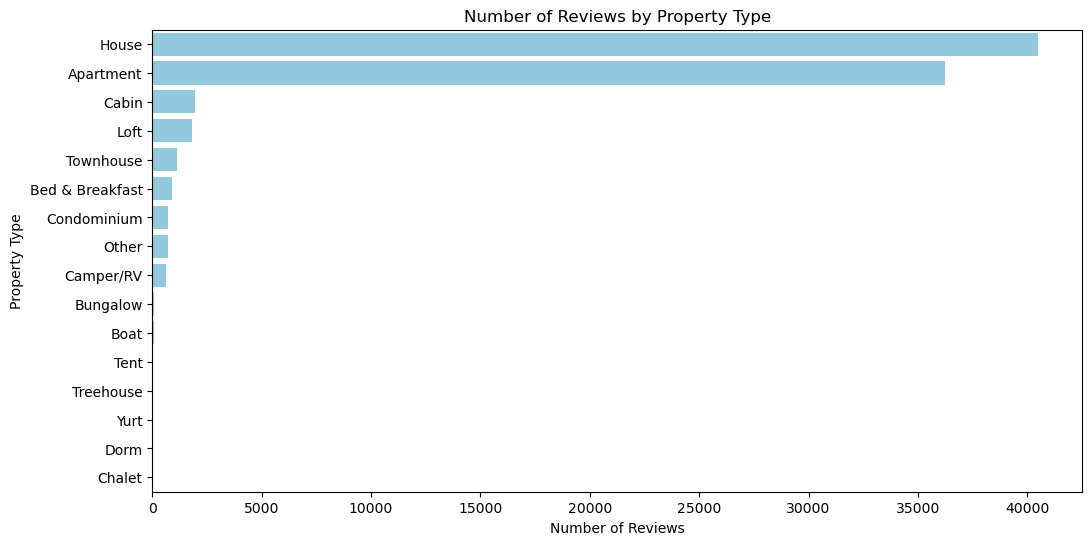

In [29]:
def plot_reviews_by_property_type(merged_data):
    """
    Plots the number of reviews for each property type.
    
    Parameters:
    - merged_data (pd.DataFrame): The dataframe containing merged reviews and listings data 
                                  with a 'property_type' column.
    
    Returns:
    - A bar plot visualizing the number of reviews for each property type.
    """
    
    # Counting the number of reviews by property type
    reviews_by_property_type = merged_data['property_type'].value_counts().reset_index()
    reviews_by_property_type.columns = ['property_type', 'count']

    # Plotting the number of reviews by property type
    plt.figure(figsize=(12, 6))
    sns.barplot(x='count', y='property_type', data=reviews_by_property_type, color='skyblue')
    plt.title('Number of Reviews by Property Type')
    plt.xlabel('Number of Reviews')
    plt.ylabel('Property Type')
    plt.show()

# Implement Function
plot_reviews_by_property_type(merged_reviews_data)


#### Average Ratings Across Neighborhoods

Next, we'll investigate how different neighborhoods or areas are rated by guests.


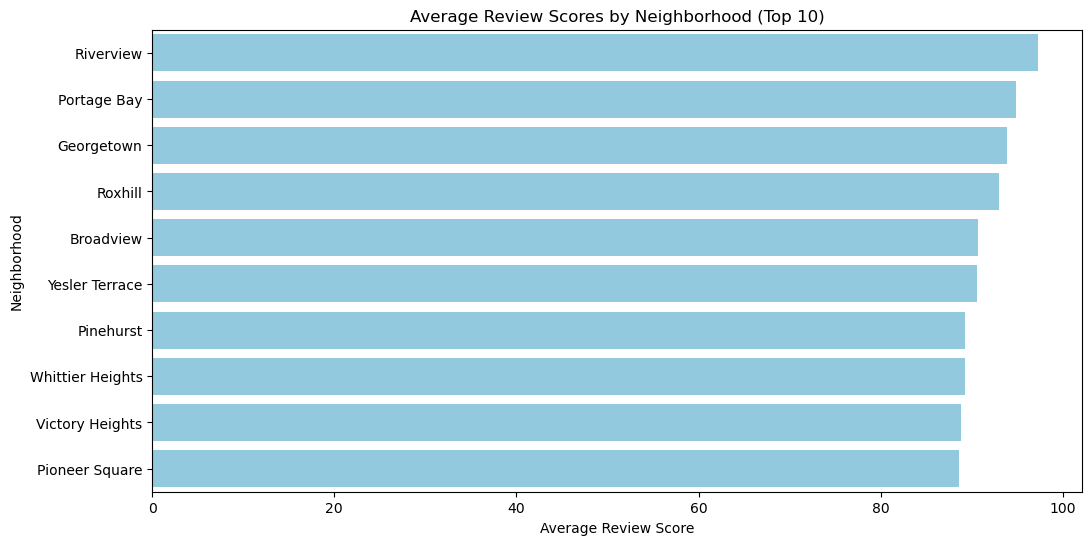

In [30]:
def plot_top_neighborhoods_by_review_score(df, top_n=10):
    """
    Plots the top neighborhoods based on their average review scores.
    
    Parameters:
    - df (pd.DataFrame): The listings dataframe containing 'neighbourhood_cleansed' and 'review_scores_rating' columns.
    - top_n (int, optional): The number of top neighborhoods to display. Default is 10.
    
    Returns:
    - A bar plot visualizing the average review scores for the top neighborhoods.
    """
    
    # Selecting relevant columns from the listings DataFrame for neighborhood analysis
    neighborhood_ratings = df[['neighbourhood_cleansed', 'review_scores_rating']]

    # Calculating the average review scores by neighborhood
    average_ratings_by_neighborhood = neighborhood_ratings.groupby('neighbourhood_cleansed')['review_scores_rating'].mean().reset_index()

    # Sorting by average rating
    average_ratings_by_neighborhood = average_ratings_by_neighborhood.sort_values(by='review_scores_rating', ascending=False)

    # Plotting the average review scores by neighborhood (Top 10 neighborhoods)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='review_scores_rating', y='neighbourhood_cleansed', data=average_ratings_by_neighborhood.head(top_n), color='skyblue')
    plt.title(f'Average Review Scores by Neighborhood (Top {top_n})')
    plt.xlabel('Average Review Score')
    plt.ylabel('Neighborhood')
    plt.show()

# Implement function
plot_top_neighborhoods_by_review_score(listings_df)


#### Seasonal Trends in Reviews

Finally, we'll examine how review patterns change throughout the year.


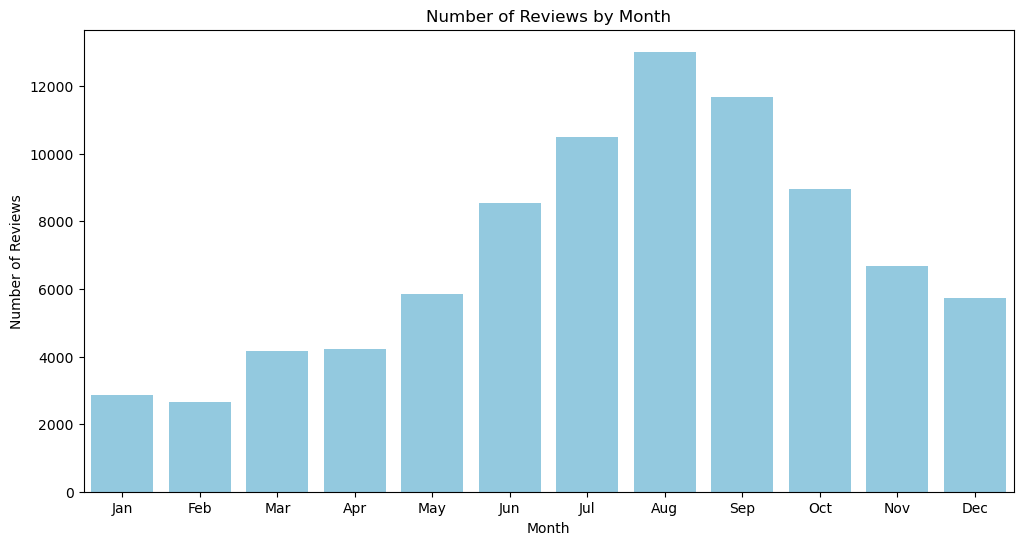

In [31]:
def plot_reviews_by_month(df):
    """
    Plots the number of reviews by month based on the 'date' column in the provided dataframe.
    
    Parameters:
    - df (pd.DataFrame): The dataframe containing a 'date' column with review dates.
    
    Returns:
    - None: Displays a bar plot showing the number of reviews for each month.
    """
    
    # Converting the date column to a datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Extracting the month from the date
    df['month'] = df['date'].dt.month

    # Counting the number of reviews by month
    reviews_by_month = df['month'].value_counts().sort_index().reset_index()
    reviews_by_month.columns = ['month', 'count']

    # Plotting the number of reviews by month
    plt.figure(figsize=(12, 6))
    sns.barplot(x='month', y='count', data=reviews_by_month, color='skyblue', order=range(1, 13))
    plt.title('Number of Reviews by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Reviews')
    plt.xticks(ticks=range(12), labels=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
    ])
    plt.show()

# Testing the function (will execute only if data is available)
plot_reviews_by_month(merged_reviews_data)


#### Insights

- **For Hosts:**
   - **Embrace Popular Choices:** Focus on property types that resonate with guests.
   - **Location, Location, Location:** Enhance experiences in top-rated areas.
   - **Seasonal Sensitivity:** Cater to seasonal trends.

- **For Travelers:**
   - **Choose Wisely:** Seek popular property types and highly-rated neighborhoods.
   - **Seasonal Adventures:** Align travels with seasonal insights.


### Conclusion

This exploration has provided valuable insights into the dynamics of shared accommodations on platforms like Airbnb. Whether you're a host looking to optimize your listings or a traveler planning your next adventure, these data-driven insights offer a roadmap to delightful experiences. Happy hosting and happy travels!
